# Data Science in Economics and Business - Class Project
In this class project, you are supposed to work with experimental data from the paper "The Many Faces of Human Sociality: Uncovering the Distribution and Stability of Social Preferences" by Bruhin, Fehr, and Schunk, published in the *Journal of the European Economic Association* 17(4): 1025-1069, 2019: https://doi.org/10.1093/jeea/jvy018

**IMPORTANT:** <br>
Please enter the matriculation number of all group members here:
1. XXXXXX
2. YYYYYY
3. ZZZZZZ

In this class project, you will use the different techniques taught in the course: data handling, data visualization, and machine learning.

First load the necessary packages. <br>
If you want to use additional libraries you can add them to the following cell:

The authors observe human behavior in the so-called dictator game: One player (*dictator*) receives a certain amount of money and can distribute this endowment between herself and another player (*receiver*). The decision of the dictator is implemented, and the receiver has no choice to take and must accept the dictator's decision. <br>
The authors employ a binary version of the dictator game in which the dictator can choose between two alternative allocation options *X* and *Y*. Each dictator in the experiment plays 30 of these dictator games with varying pairs of decision alternatives. <br>
All subjects in the experiment were students from the University of Zurich and the Swiss Federal Institute of Technology Zurich.

# Problem 1 - Data Handling
The basis of your work will be the following two datasets:
- `choices.csv` contains the decisions of the dictators across the 30 variations of the binary dictator game.
    - *sid* is the ID of the subject.
    - *gid* is the ID of the game variation.
    - *order* is the (random) order in which the game appeared in the block of dictator games.
    - *self_x* and *self_y* are the payoffs of the dictator in choice option X and Y, respectively.
    - *other_x* and *other_y* are the payoffs of the receiver in choice option X and Y, respectively.
    - *choice_x* describes the decision of the dictator, with a value of 1 representing the choice of option X, and 0 the choice of option Y.
    - *s_x* and *s_y* are indicators of disadvantageous inequality for the dictator in option X and option Y, respectively. That is, *s_x* equals 1 if the dictator receives lower payoff in option X than the receiver, and 0 if the dictator receive higher payoff in option X than the receiver.
    - *r_x* and *r_y* are indicators of advantageous inequality for the dictator in option X and option Y, respectively. That is, *r_x* equals 1 if the dictator receives higher payoff in option X than the receiver, and 0 if the dictator receive lower payoff in option X than the receiver.
    - Note that *r_x = 1 - s_x* and *r_y = 1 - s_y*
- `subjects.csv` contains the results from the post-experimental questionnaire.
    - *sid* is the ID of the subject.
    - *bf_consciousness, bf_openness, bf_extraversion, bf_agreeableness, bf_neuroticism* are the results from the Big Five measures.
    - *cogabil* is a measure of cognitive ability.
    - *pe_D1_stud_natsci, pe_D1_stud_law, pe_D1_stud_socsci, pe_D1_stud_med* indicate the subject's field of study (natural sciences, law, social sciences, or medicine, respectively).
    - *pe_monthinc* is the subject's monthly income.
    - *pe_age* is the subject's age.
    - *pe_female* equals 1 if the subject is female, and 0 otherwise.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import folium
from folium.plugins import MarkerCluster
from sklearn.preprocessing import LabelEncoder

choices_df = pd.read_csv('choices.csv')
subjects_df = pd.read_csv('subjects.csv')

#### a)
Merge the two datasets into one. <br>
Check whether you have behavioral data (from `choices`) and personal information (from `subjects`) on all subjects. <br>
If not, create an indicator for missing data and list the IDs of the subjects concerned.

In [26]:
#Merge the datasets on 'sid'
merged_data = pd.merge(choices_df, subjects_df, on='sid', how='outer', indicator=True)

#Check for missing data
missing_behavioral = merged_data[merged_data['_merge'] == 'left_only']
missing_personal = merged_data[merged_data['_merge'] == 'right_only']

#Create indicators for missing data
merged_data['missing_behavioral'] = merged_data['_merge'] == 'left_only'
merged_data['missing_personal'] = merged_data['_merge'] == 'right_only'

#List the IDs of the subjects with missing data
missing_behavioral_ids = missing_behavioral['sid'].unique()
missing_personal_ids = missing_personal['sid'].unique()

#Add two new colums for evaluation
merged_data['dictator_payoff_difference'] = merged_data['self_x'] - merged_data['self_y']
merged_data['receiver_payoff_difference'] = merged_data['other_x'] - merged_data['other_y']
merged_data['chosen_option'] = merged_data['choice_x'].apply(lambda x: 'X' if x == 1 else 'Y')


print("Subjects with missing behavioral data (choices):")
print(missing_behavioral_ids)
print("\nSubjects with missing personal information (subjects):")
print(missing_personal_ids)
merged_data.drop(columns=['_merge'], inplace=True)
print("\nMerged Dataset with Missing Data Indicators:")
print(merged_data.head())

Subjects with missing behavioral data (choices):
[102010050706  62010050706 202010050704 122010050603 172010050501
 212010050704 362010050501  82010050705 162010050502 192010050502
 292010050502 132010050706 152010050706 172010050704]

Subjects with missing personal information (subjects):
[]

Merged Dataset with Missing Data Indicators:
            sid  gid  order  self_x  self_y  other_x  other_y  choice_x  s_y  \
0  102010050706  361      1     940     800      150      510         0    0   
1  102010050706  281      2     970     770      490      170         0    0   
2  102010050706  391      3    1060     680      330      330         1    0   
3  102010050706  271      4     990     750      480      180         1    0   
4  102010050706  311      5     930     810      510      150         0    0   

   s_x  ...  pe_D1_stud_socsci  pe_D1_stud_med  pe_monthinc  pe_age  \
0    0  ...                NaN             NaN          NaN     NaN   
1    0  ...                NaN       

#### b)
Try out different representations of the data (long vs. wide etc.).

In [ ]:
wide_format = merged_data.pivot_table(index='sid', columns='gid',
                                      values=['choice_x', 'self_x', 'self_y', 'other_x', 'other_y', 'order', 's_x', 's_y', 'r_x', 'r_y'],
                                      aggfunc='first')

# Flatten the multi-level columns for better readability
wide_format.columns = ['_'.join(map(str, col)).strip() for col in wide_format.columns.values]
wide_format.reset_index(inplace=True)

print("\nWide Format Representation:")
print(wide_format.head())

# Step 5: Long format representation
# Melt the dataset to get a long format
long_format = pd.melt(merged_data, id_vars=['sid', 'gid', 'order'],
                      value_vars=['choice_x', 'self_x', 'self_y', 'other_x', 'other_y', 's_x', 's_y', 'r_x', 'r_y'],
                      var_name='variable', value_name='value')

print("\nLong Format Representation:")
print(long_format.head())


Wide Format Representation:
           sid  choice_x_11  choice_x_21  choice_x_31  choice_x_41  \
0  12010050501            1            1            1            1   
1  12010050502            1            1            1            1   
2  12010050603            1            1            0            0   
3  12010050704            1            1            1            1   
4  12010050705            1            1            1            1   

   choice_x_51  choice_x_61  choice_x_71  choice_x_81  choice_x_91  ...  \
0            1            1            1            1            1  ...   
1            1            1            1            0            0  ...   
2            1            0            1            1            1  ...   
3            1            1            1            1            1  ...   
4            1            1            1            0            0  ...   

   self_y_301  self_y_311  self_y_321  self_y_331  self_y_341  self_y_351  \
0         830         

# Problem 2 - Data Visualization
#### a)
As a first type of visualization, focus on the choices and the decision scenarios. <br>
That is, use the payoffs and indicators of (dis)advantageous inequality. <br>
You can use any kind that you deem useful: histograms, line plots, etc.

## General observations

Text(0.5, 1.0, 'Distribution of Choices (1: X, 0: Y)')

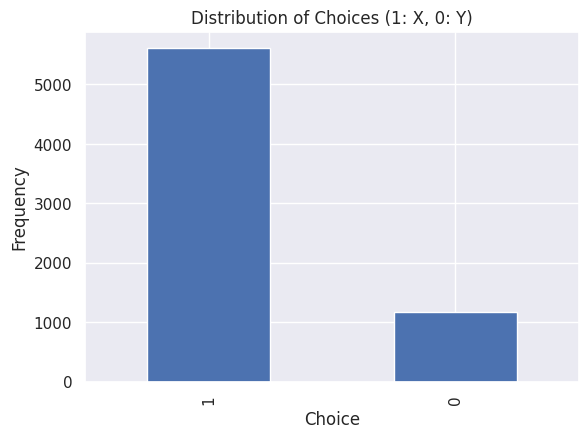

In [2]:
# Total Choices X or Y Made by Dictators
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 3)
choices_df['choice_x'].value_counts().plot(kind='bar')
plt.xlabel('Choice')
plt.ylabel('Frequency')
plt.title('Distribution of choices (1: X, 0: Y)')

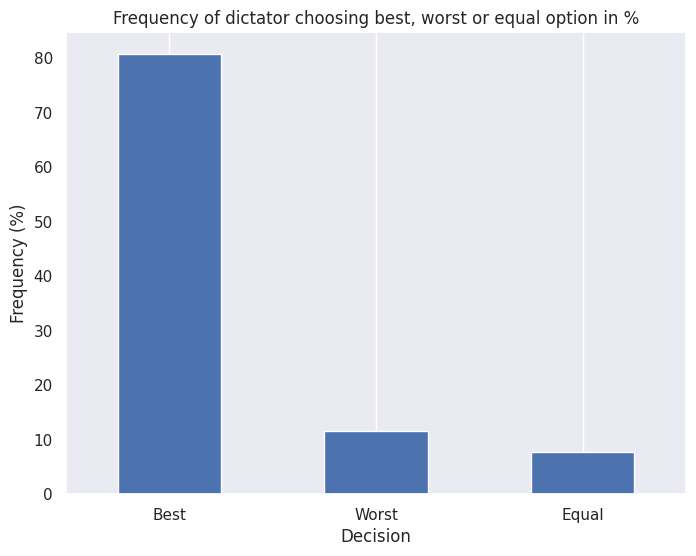

In [3]:
# Create dfs
subjects_df = pd.read_csv('subjects.csv')
choices_df = pd.read_csv('choices.csv')

# Determine if the dictator chose the best, equal, or worst option for himself
choices_df['decision'] = choices_df.apply(
    lambda row: 'Best' if (row['self_x'] > row['self_y'] and row['choice_x'] == 1) or (row['self_y'] > row['self_x'] and row['choice_x'] == 0) else (
                'Worst' if (row['self_x'] < row['self_y'] and row['choice_x'] == 1) or (row['self_y'] < row['self_x'] and row['choice_x'] == 0) else 'Equal'),
    axis=1
)

# Calculate the frequency of each decision
decision_counts = choices_df['decision'].value_counts(normalize=True) * 100

# Bar chart for decisions
plt.figure(figsize=(8, 6))
decision_counts.plot(kind='bar')
plt.xlabel('Decision')
plt.ylabel('Frequency (%)')
plt.title('Frequency of dictator choosing best, worst or equal option in %')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

### We can see that the dictator both tends to choose Option X and the stronger option for himself most of the time. Therefore we could derive that Option X appears to be more favorable towards the dictator for the analysed games.

## Analysis advantageous inequality

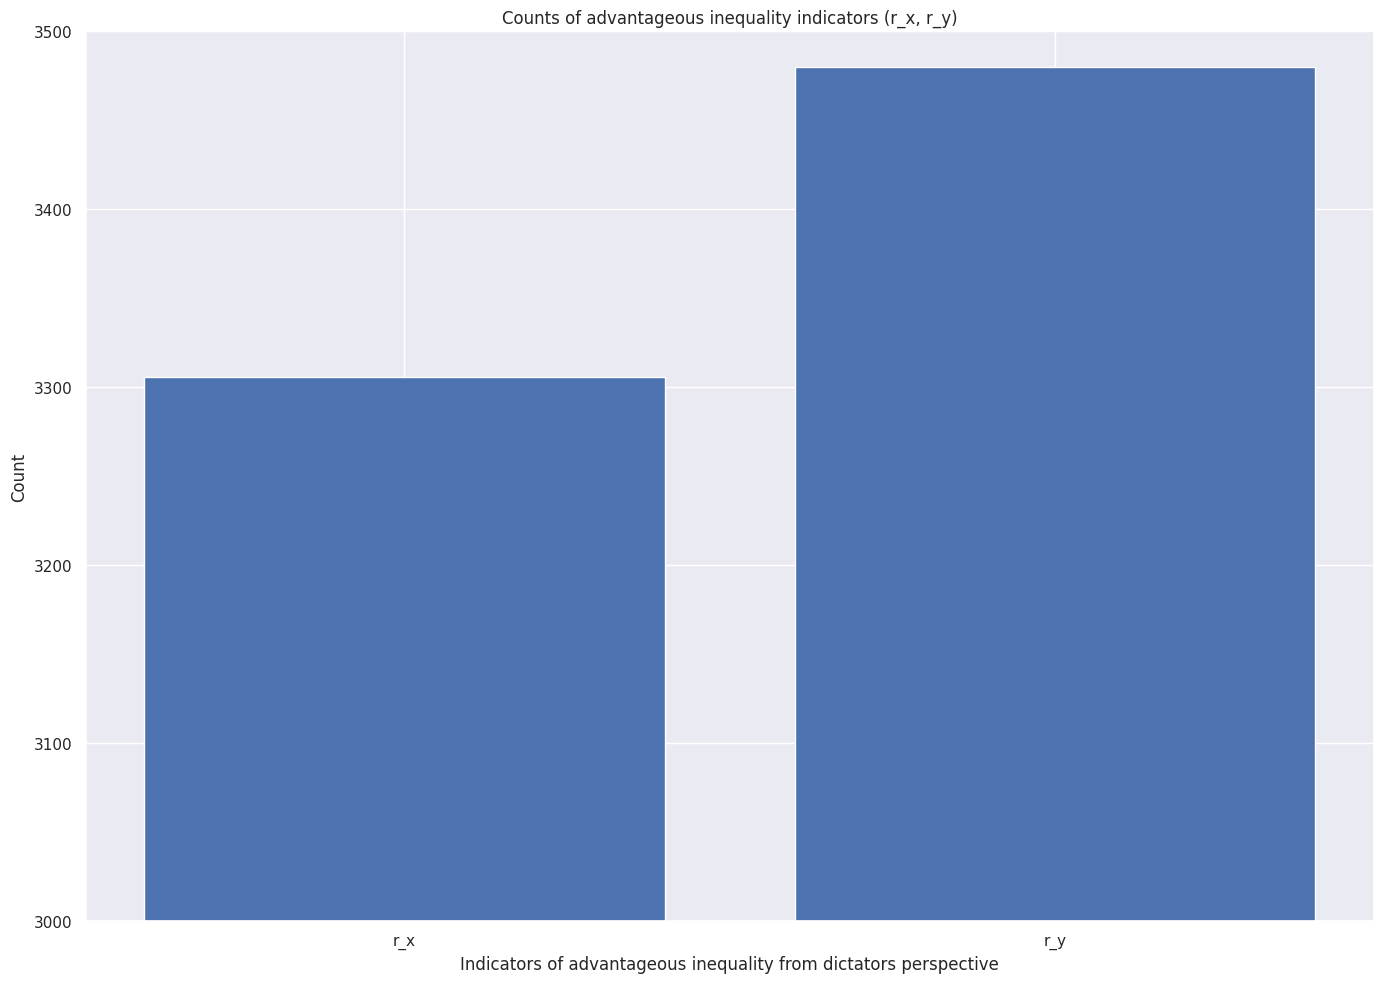

In [4]:
# Counting Indicators of Inequality (only once since s_x = 1-r_x)
# Summing the counts for r_x and r_y where they are 1
r_x_count = choices_df[choices_df['r_x'] == 1]['r_x'].count()
r_y_count = choices_df[choices_df['r_y'] == 1]['r_y'].count()

# Plot
plt.figure(figsize=(14, 10))
plt.bar(['r_x', 'r_y'], [r_x_count, r_y_count], log=False)
plt.ylim(3000, 3500)
plt.xlabel('Indicators of advantageous inequality from dictators perspective')
plt.ylabel('Count')
plt.title('Counts of advantageous inequality indicators (r_x, r_y)')
plt.tight_layout()
plt.show()

### However, when looking at the advantageous inequality, we can see that for option Y the dictators payoff tends to be higher than the receivers more often.This implies that the Dictator generally values his own absolute benefit over the higher difference compared to the receiver when making a decision.

<ipython-input-12-7c1b773f958a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_option_df['options_delta'] = best_option_df.apply(lambda row: abs(row['self_x'] - row['self_y']), axis=1)
<ipython-input-12-7c1b773f958a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_option_df['options_delta'] = best_option_df.apply(lambda row: abs(row['self_x'] - row['self_y']), axis=1)


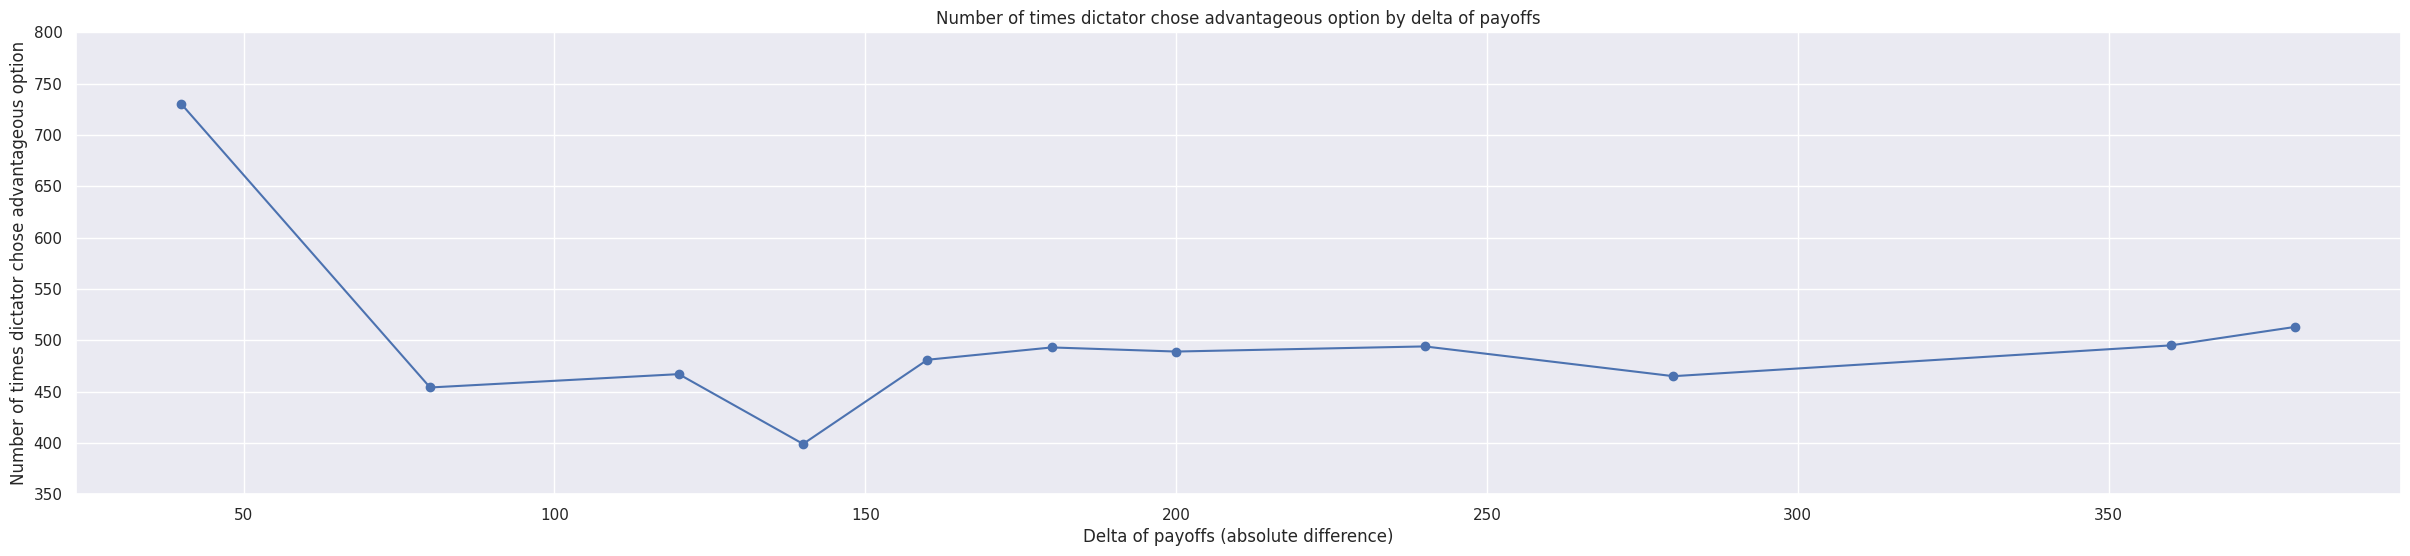

<ipython-input-12-7c1b773f958a>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_optimal_option_df['options_delta'] = non_optimal_option_df.apply(lambda row: abs(row['self_x'] - row['self_y']), axis=1)
<ipython-input-12-7c1b773f958a>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_optimal_option_df['options_delta'] = non_optimal_option_df.apply(lambda row: abs(row['self_x'] - row['self_y']), axis=1)


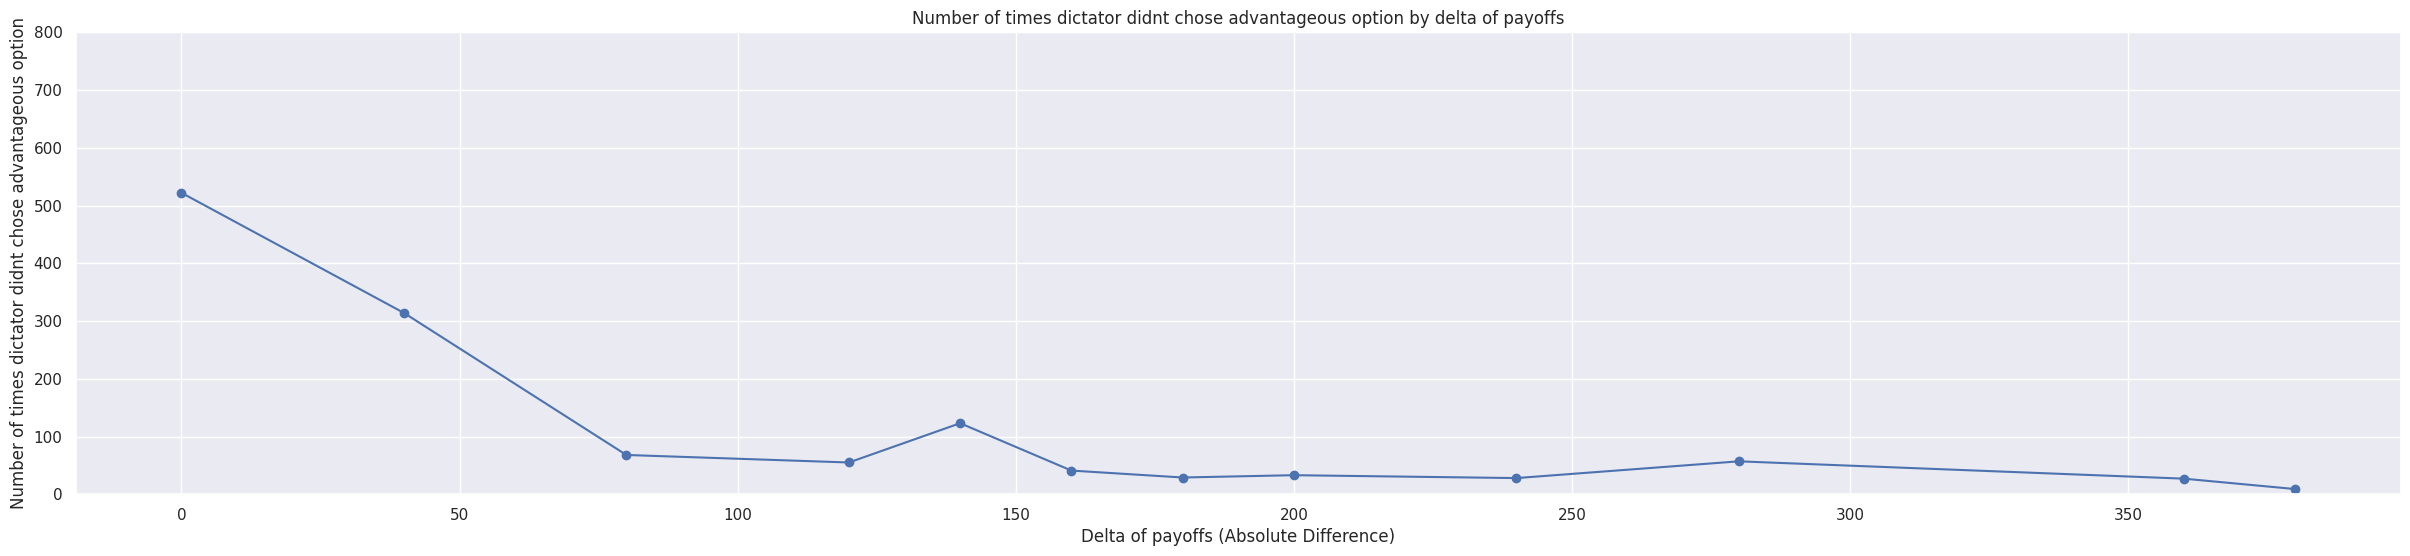

In [12]:
# Determine the dictator and receiver payoffs based on their choice
choices_df['dictator_payoff'] = choices_df.apply(lambda row: row['self_x'] if row['choice_x'] == 1 else row['self_y'], axis=1)
choices_df['receiver_payoff'] = choices_df.apply(lambda row: row['other_x'] if row['choice_x'] == 1 else row['other_y'], axis=1)

# Delta of payoffs - Analysis
# 1. Calculate delta and attach new columns to dataset
# 2. Determine if the dictator chose the best option (indicator = 1) for himself and attach indicator to dataset

# 1.
choices_df['dictator_delta'] = choices_df['self_x'] - choices_df['self_y']
choices_df['receiver_delta'] = choices_df['other_x'] - choices_df['other_y']
# 2.
choices_df['best_option_chosen'] = choices_df.apply(lambda row: 1 if (row['self_x'] > row['self_y'] and row['choice_x'] == 1) or (row['self_y'] > row['self_x'] and row['choice_x'] == 0) else 0, axis=1)

# New temporary dataset: Only where the Dictator used his priviledge to his advantage
best_option_df = choices_df[choices_df['best_option_chosen'] == 1]

# How often was the higher paying option chosen
best_option_df['options_delta'] = best_option_df.apply(lambda row: abs(row['self_x'] - row['self_y']), axis=1)
best_option_df['options_delta'] = best_option_df.apply(lambda row: abs(row['self_x'] - row['self_y']), axis=1)
delta_value_counts_advantageous = best_option_df['options_delta'].value_counts().sort_index()

# Plot
plt.figure(figsize=(30, 6))
plt.plot(delta_value_counts_advantageous.index, delta_value_counts_advantageous.values, marker='o')
plt.ylim(350, 800)
plt.xlabel('Delta of payoffs (absolute difference)')
plt.ylabel('Number of times dictator chose advantageous option')
plt.title('Number of times dictator chose advantageous option by delta of payoffs')
plt.grid(True)
plt.show()

# Same, but non-optimal decisions (both equal and worse payoffs)
non_optimal_option_df = choices_df[choices_df['best_option_chosen'] != 1]
non_optimal_option_df['options_delta'] = non_optimal_option_df.apply(lambda row: abs(row['self_x'] - row['self_y']), axis=1)
non_optimal_option_df['options_delta'] = non_optimal_option_df.apply(lambda row: abs(row['self_x'] - row['self_y']), axis=1)

delta_value_counts_non_optimal = non_optimal_option_df['options_delta'].value_counts().sort_index()

plt.figure(figsize=(30, 6))
plt.plot(delta_value_counts_non_optimal.index, delta_value_counts_non_optimal.values, marker='o')
plt.ylim(0, 800)
plt.xlabel('Delta of payoffs (Absolute Difference)')
plt.ylabel('Number of times dictator didnt chose advantageous option')
plt.title('Number of times dictator didnt chose advantageous option by delta of payoffs')
plt.grid(True)
plt.show()

### Here we can see that the higher the dictators own benefit, the more likely he is to choose the advantageous option. Also, the payout appears to be roughly within a delta of >50 for the most cases.

### For non-optimal decisions it is visible that the higher the payoff is, the less the worse option gets chosen (which confirms the above observation).

### Since Option X was chosen with a higher frequency, lets look on the payoff distribution of Option X:

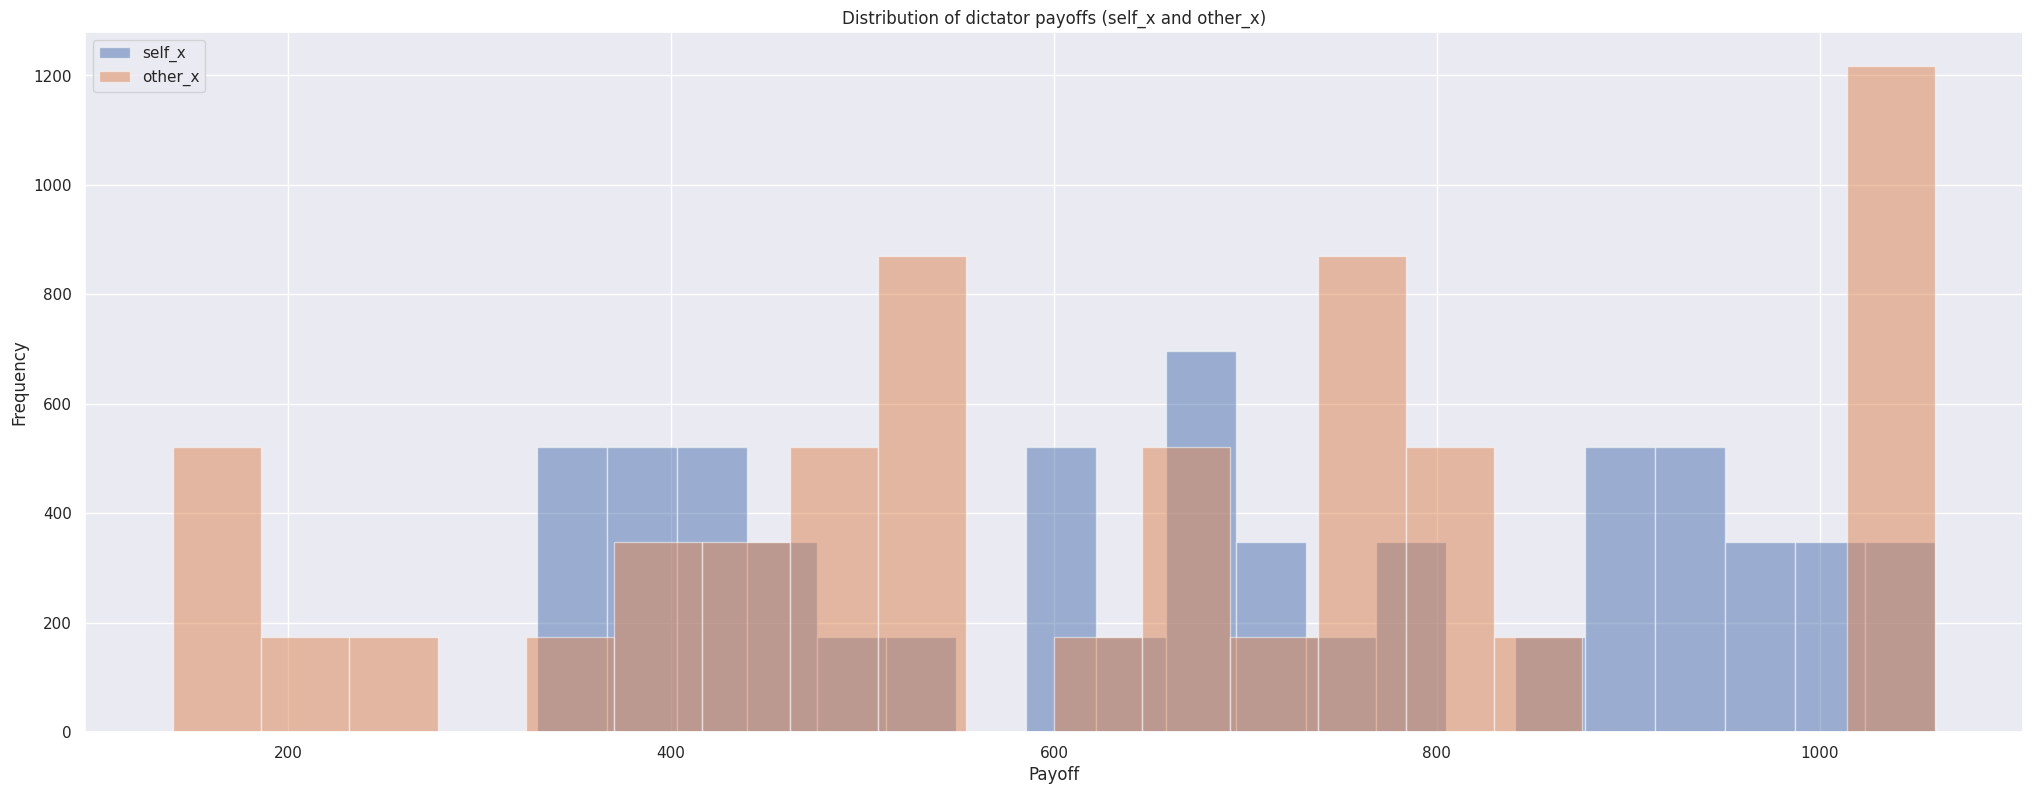

In [9]:
# Payoff Distribution of Choice X
plt.figure(figsize=(55, 20))
plt.subplot(2, 2, 1)
plt.hist(choices_df['self_x'], bins=20, alpha=0.5, label='self_x')
plt.hist(choices_df['other_x'], bins=20, alpha=0.5, label='other_x')
plt.xlabel('Payoff')
plt.ylabel('Frequency')
plt.title('Distribution of dictator payoffs (self_x and other_x)')
plt.legend()

### This plot shows that especially when the receivers payout is extremely high, the dictator tends to favor this option. This could be coincidentally or linked to a specific personality trait / gender / age. Alternatively, the options that are great for the receiver could also be the best case scenarios for the dictator.

#### b)
Now also include the information on the subjects from the questionnaires in your plots. <br>
You can use any kind that you deem useful: histograms, line plots, etc.

# Prepare dataset

### Focus here is the highest paying (optimal) decision for the dictator since that appears to be the driving factor.

In [13]:
# How does the choices_df look atm?
choices_df

,sid,gid,order,self_x,self_y,other_x,other_y,choice_x,s_y,s_x,r_y,r_x,decision,dictator_payoff,receiver_payoff,dictator_delta,receiver_delta,best_option_chosen
0,102010050706,361,1,940,800,150,510,0,0,0,1,1,Worst,800,510,140,-360,0
1,102010050706,281,2,970,770,490,170,0,0,0,1,1,Worst,770,170,200,320,0
2,102010050706,391,3,1060,680,330,330,1,0,0,1,1,Best,1060,330,380,0,1
3,102010050706,271,4,990,750,480,180,1,0,0,1,1,Best,990,480,240,300,1
4,102010050706,311,5,930,810,510,150,0,0,0,1,1,Worst,810,150,120,360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6781,172010050704,251,35,780,420,540,660,1,1,0,0,1,Best,780,540,360,-120,1
6782,172010050704,191,36,680,520,780,420,0,0,1,1,0,Worst,520,420,160,360,0
6783,172010050704,221,37,620,580,410,790,1,1,0,0,1,Best,620,410,40,-380,1
6784,172010050704,231,38,670,530,420,780,1,1,0,0,1,Best,670,420,140,-360,1


In [70]:
# Reduce size of dataframe
choices_df_reduced = choices_df.drop(['order', 'self_x', 'self_y', 'other_x', 'other_y'], axis=1)

# Inner merge od two datasets
merged_df = pd.merge(choices_df_reduced, subjects_df, on='sid', how='inner')

# Encode decision column and further slimming down
label_encoder = LabelEncoder()
merged_df['decision_encoded'] = label_encoder.fit_transform(merged_df['decision'])
merged_df_encoded = merged_df.drop(['decision', 'choice_x', 's_y', 's_x', 'r_y', 'r_x'], axis=1)

merged_df_encoded: Relies on previous transformations regarding making the best decision including deltas and payoffs

In [33]:
#Download slim dataframe for easier later usage
from google.colab import files
merged_df_encoded.to_csv('/content/merged_df_encoded.csv', index=False)
files.download('/content/merged_df_encoded.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Influence of Big 5 on optimal decision
optimal -> higher absolute payoff
        

non-optimal -> equal or lower payoff

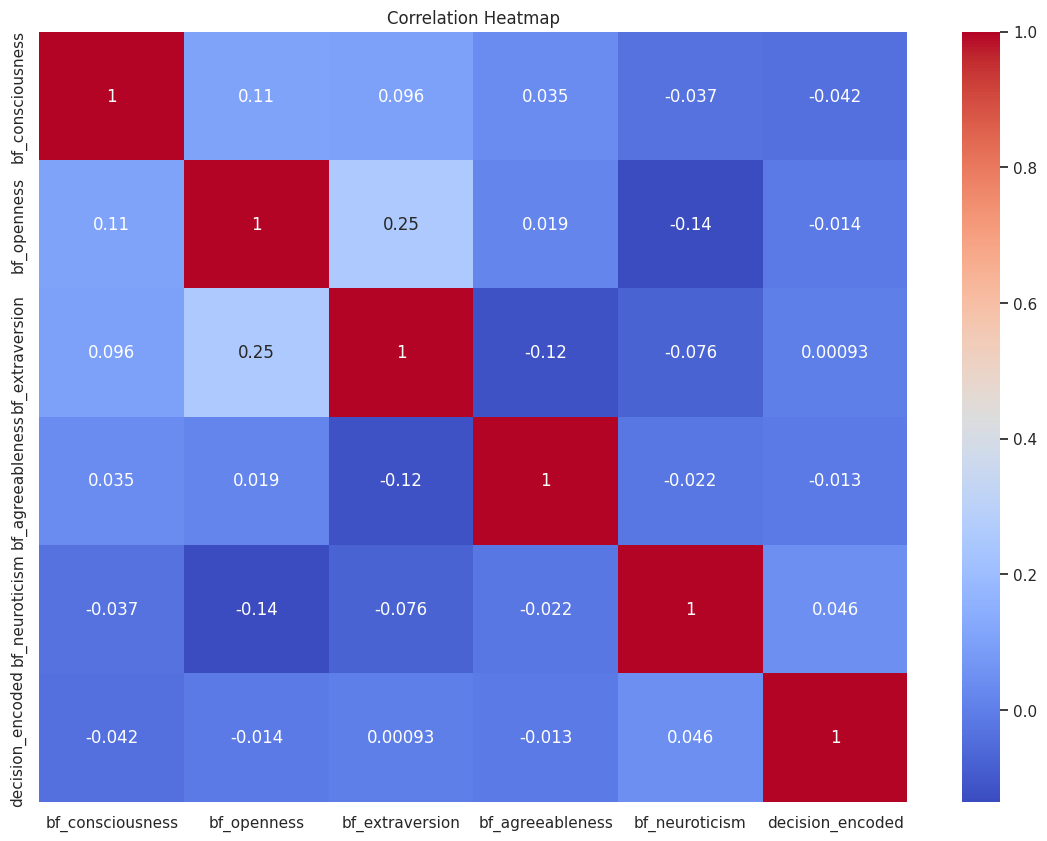

In [69]:
big_5_df_minimal = merged_df_encoded.drop(['sid','gid','dictator_payoff', 'receiver_payoff', 'dictator_delta', 'best_option_chosen', 'receiver_delta','cogabil','pe_D1_stud_natsci', 'pe_D1_stud_law', 'pe_D1_stud_socsci', 'pe_D1_stud_med', 'pe_monthinc', 'pe_age', 'pe_female'], axis=1)


plt.figure(figsize=(14, 10))
correlation_matrix = big_5_df_minimal.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### We can see that there are no significant relations between the Big 5 and the decision to take the better option (column on the right or last row). Especially extraversion appears to have no correlation to the decision to take the higher payoff.

# Decisions by biological gender (optimal and non-optimal)
optimal -> higher absolute payoff
        

non-optimal -> equal or lower payoff

The general distribution of genders in the dataset is as follows:
- Female (pe_female = 1): 3276 entries
- Male (pe_female = 0): 2964 entries
This indicates that the dataset contains slightly more females than males.



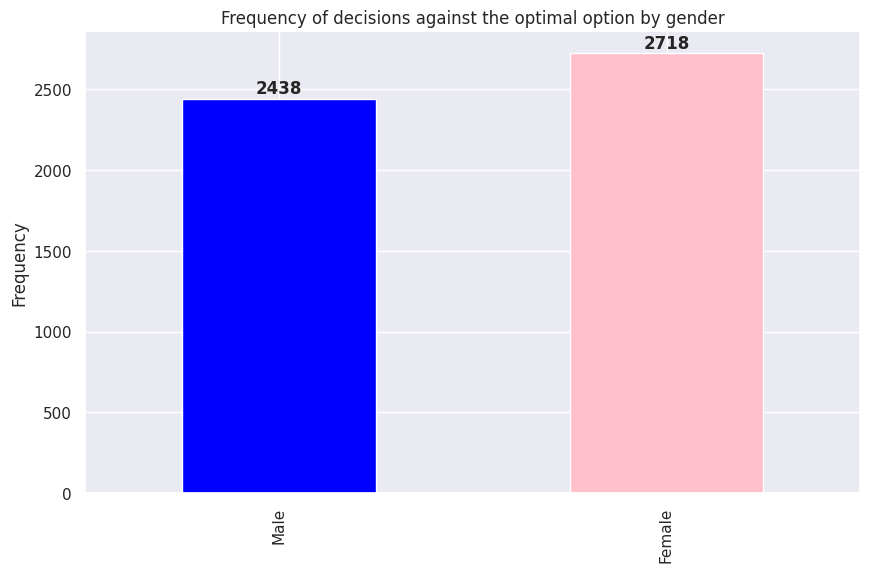

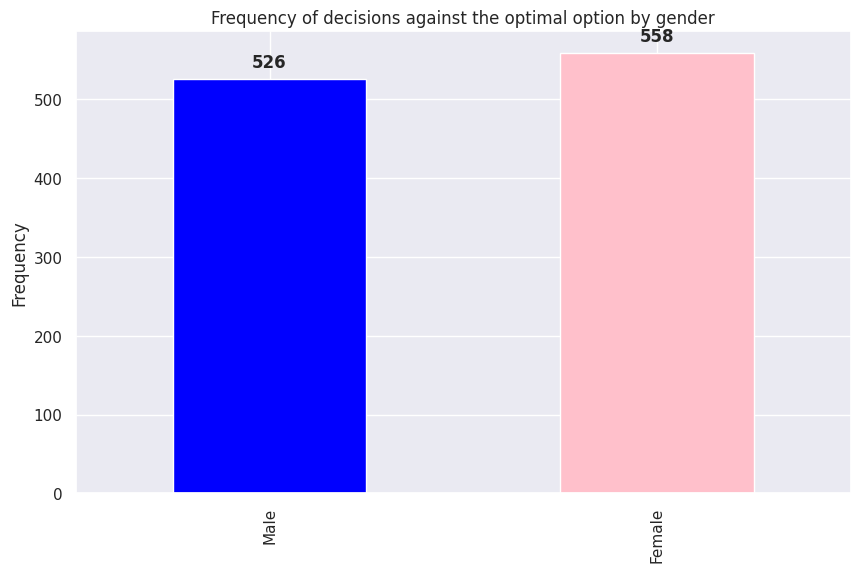

In [83]:
gender_distribution = merged_df_encoded['pe_female'].value_counts()
total_counts = merged_df_encoded['pe_female'].sum()

percentage_optimal_decisions = (decision_counts_positive / total_counts) * 100

print(f"The general distribution of genders in the dataset is as follows:\n"
      f"- Female (pe_female = 1): {gender_distribution[1]} entries\n"
      f"- Male (pe_female = 0): {gender_distribution[0]} entries\n"
      f"This indicates that the dataset contains slightly more females than males.\n")

#Optimal and Non-optimal decisions by gender
#Optimal
decision_counts_positive = merged_df_encoded[merged_df_encoded['decision_encoded'] == 0].groupby('pe_female').size()

plt.figure(figsize=(10, 6))
ax = decision_counts_positive.plot(kind='bar', color=['blue', 'pink'])
plt.title('Frequency of decisions against the optimal option by gender')
plt.ylabel('Frequency')
plt.xlabel('')
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
for i, count in enumerate(decision_counts_positive):
    ax.text(i, count + 10, str(count), ha='center', va='bottom', fontweight='bold')
plt.show()

#Non-ptimal
decision_counts_negative = merged_df_encoded[merged_df_encoded['decision_encoded'] != 0].groupby('pe_female').size()

plt.figure(figsize=(10, 6))
ax = decision_counts_negative.plot(kind='bar', color=['blue', 'pink'])
plt.title('Frequency of decisions against the optimal option by gender')
plt.ylabel('Frequency')
plt.xlabel('')
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
for i, count in enumerate(decision_counts_negative):
    ax.text(i, count + 10, str(count), ha='center', va='bottom', fontweight='bold')
plt.show()

### We can see that biological gender does not seem to affect the decisions a lot. There is a very slight tendency that female test subjects tend to decide against the best decision a little more often, but not by much.

# Decisions by Age (optimal and non-optimal)
optimal -> higher absolute payoff
        

non-optimal -> equal or lower payoff

<ipython-input-75-c5c87e6abe90>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decision_counts_age = merged_df_encoded[merged_df_encoded['decision_encoded'] == 0].groupby('age_group').size()


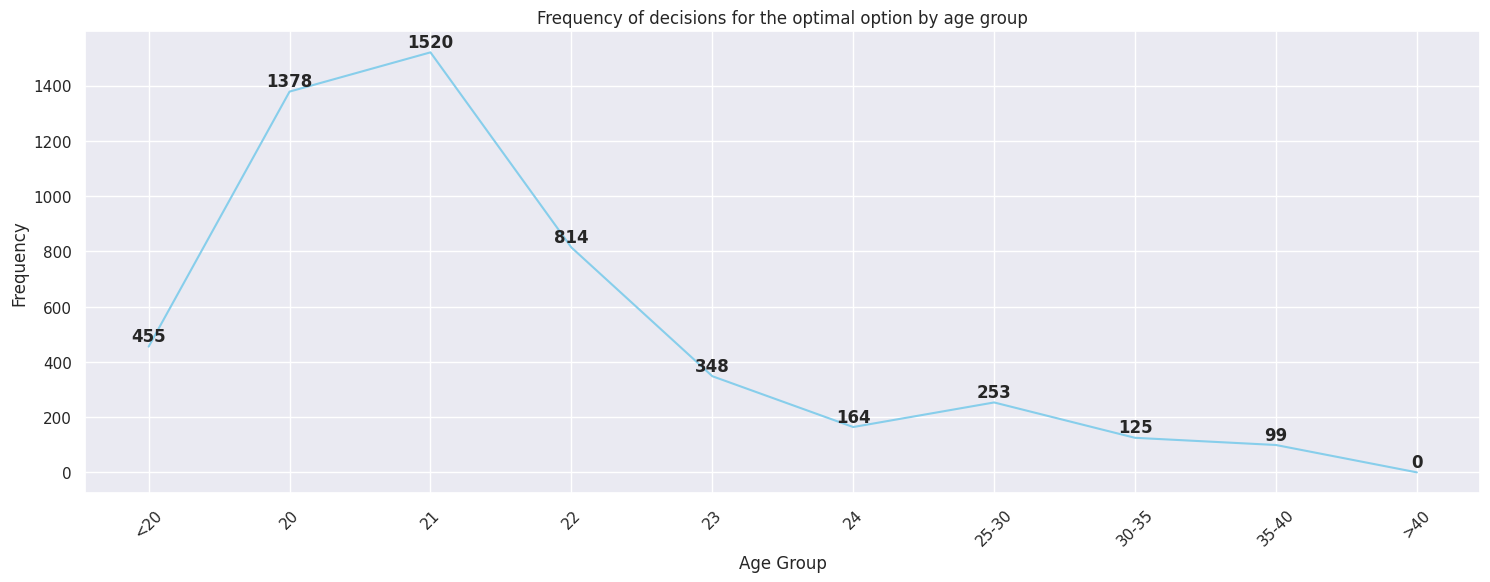

In [75]:
# Optimal decision
age_bins = [0, 20, 21, 22, 23, 24, 25, 30, 35, 40, 150]
age_labels = ['<20', '20', '21', '22', '23', '24', '25-30', '30-35', '35-40', '>40']
merged_df_encoded['age_group'] = pd.cut(merged_df_encoded['pe_age'], bins=age_bins, labels=age_labels, right=False)

decision_counts_age = merged_df_encoded[merged_df_encoded['decision_encoded'] == 0].groupby('age_group').size()

plt.figure(figsize=(18, 6))
ax = decision_counts_age.plot(kind='line', color='skyblue')
plt.title('Frequency of decisions for the optimal option by age group')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
ax.set_xticks(range(len(age_labels)))
ax.set_xticklabels(age_labels)
for i, count in enumerate(decision_counts_age):
    ax.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')

plt.show()

<ipython-input-76-253269b62a6a>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decision_counts_age = merged_df_encoded[merged_df_encoded['decision_encoded'] != 0].groupby('age_group').size()


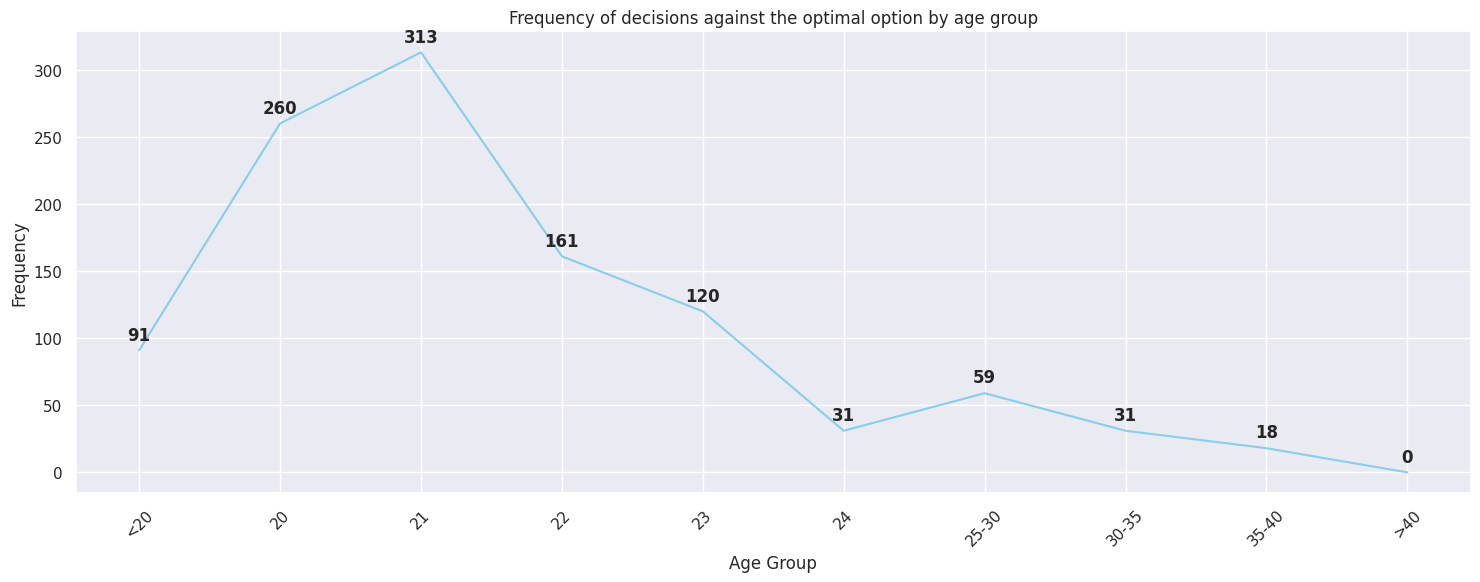

In [76]:
# Non-optimal decision
age_bins = [0, 20, 21, 22, 23, 24, 25, 30, 35, 40, 150]
age_labels = ['<20', '20', '21', '22', '23', '24', '25-30', '30-35', '35-40', '>40']
merged_df_encoded['age_group'] = pd.cut(merged_df_encoded['pe_age'], bins=age_bins, labels=age_labels, right=False)

decision_counts_age = merged_df_encoded[merged_df_encoded['decision_encoded'] != 0].groupby('age_group').size()

plt.figure(figsize=(18, 6))
ax = decision_counts_age.plot(kind='line', color='skyblue')
plt.title('Frequency of decisions against the optimal option by age group')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
ax.set_xticks(range(len(age_labels)))
ax.set_xticklabels(age_labels)
for i, count in enumerate(decision_counts_age):
    ax.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')

plt.show()

merged_df_encoded = merged_df_encoded.drop(['age_group'], axis=1)

### The distributions for both optimal and non-optimal decisions are very similar. Therefore, the age of the dictator also des not seem to influence the optimal decision.
Note: The age group 20-25 has been split since the high count of subjects in this range.

# Decisions by study background (optimal or non-optimal)
optimal -> higher absolute payoff
        

non-optimal -> equal or lower payoff

The percentage of people from each area that decided on the optimal decision is as follows:
- pe_D1_stud_natsci: 82.55%
- pe_D1_stud_law: 84.38%
- pe_D1_stud_socsci: 82.50%
- pe_D1_stud_med: 85.38%


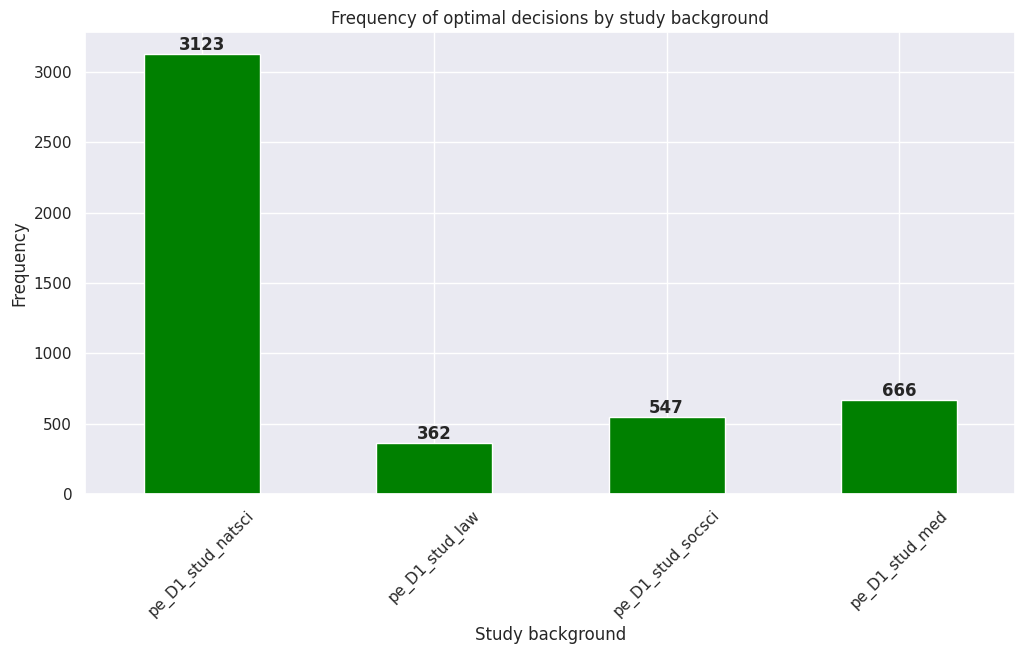

In [82]:
pe_D1_columns = [col for col in merged_df_encoded.columns if col.startswith('pe_D1_')]
best_decision_counts = merged_df_encoded[merged_df_encoded['decision_encoded'] == 0][pe_D1_columns].sum()

# Plotting the results
plt.figure(figsize=(12, 6))
ax = best_decision_counts.plot(kind='bar', color='green')
plt.title('Frequency of optimal decisions by study background')
plt.xlabel('Study background')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
for i, count in enumerate(best_decision_counts):
    ax.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')

# Calculating the percentage of people from each area that decided on the optimal decision
optimal_decisions = merged_df_encoded[merged_df_encoded['decision_encoded'] == 0][pe_D1_columns].sum()
total_counts = merged_df_encoded[pe_D1_columns].sum()
percentage_optimal_decisions = (optimal_decisions / total_counts) * 100
print(f"The percentage of people from each area that decided on the optimal decision is as follows:\n"
      f"- pe_D1_stud_natsci: {percentage_optimal_decisions['pe_D1_stud_natsci']:.2f}%\n"
      f"- pe_D1_stud_law: {percentage_optimal_decisions['pe_D1_stud_law']:.2f}%\n"
      f"- pe_D1_stud_socsci: {percentage_optimal_decisions['pe_D1_stud_socsci']:.2f}%\n"
      f"- pe_D1_stud_med: {percentage_optimal_decisions['pe_D1_stud_med']:.2f}%")


plt.show()


### When looking at the absolute numers, it appears that NatSci students take the best decisions the most. However, the relative numbers show that there is no (or a very weak (law and medicine tend to favor the better option a little bit more)) correlation between the study background and making the optimal decision for oneself.

# Problem 3 - Supervised Machine Learning
#### a)
Try to predict the choices of subjects using the information provided. <br>
Report the performance measures for different predictor variables.

In [ ]:
# Insert your code here.

#### b)
Try to fill the gaps in the data using appropriate prediction models.

In [ ]:
# Insert your code here.

#### c)
The questionnaire by Bruhin et al. comprises personality traits according to the Big Five. <br>
This question asks you to impute other (economic) preferences of the study participants. <br>
Examples include:
- Social preferences (inequity aversion, reciprocity, guilt aversion...)
- Time preferences (myopia, present bias...)
- Risk preferences
- ...

Your taks is thus the following:
1. Find a dataset on individuals that contains the Big Five along with other preference measures. Think of datasets used in scientific publications.
2. Train models to predict the other preferences from the Big Five. Evaluate their performance.
3. Make an out-of sample prediction using the fitted models to impute the preference measures for the study participants of Bruhin et al.

In [ ]:
# Insert your code here.

# Problem 4 - Unsupervised Machine Learning
Use subjects' behaviors and information from the questionnaire to cluster individuals. <br>
Which is the optimal number of clusters? <br>
Can you provide an intuition for the clusters you identified? <br>
Do the clusters change when you include the imputed preferences from Problem 3c)?

In [ ]:
# Insert your code here.